In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter
import random 
import csv
from scipy.interpolate import interp2d
from sklearn.cluster import KMeans
import warnings
from matplotlib.cm import ScalarMappable
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def wind_eval(orig_height, target_height, ds, surface_roughness):
    """Takes in an xarray dataset and evaluates the wind speed magnitude at a certain height using formula, 
    then creates a new variables and assigns it to the database and replaces the original wind speed magnitude.
    Note: Sets values of wind magnitude > 25m/s to zero."""
    #creating magnitude
    ds = ds.assign(wind_mag=lambda ds: np.sqrt(ds.u100**2 + ds.v100**2))
    
    #function to adjust for height of wind turbine
    def multiply(x,surface_roughness=surface_roughness,orig_height=orig_height,target_height=target_height):
        alpha = 0.5*(surface_roughness/10)**0.2
        factor = (target_height/orig_height)**alpha
        return x*factor
        
    ds['wind_mag'] = xr.apply_ufunc(multiply, ds['wind_mag'],input_core_dims=[["longitude","latitude"]],
               output_core_dims=[["longitude", "latitude"]], dask = 'allowed', vectorize = True)
    #dropping values above 25ms-1 (cut-out speed)
    ds['wind_mag'] = ds['wind_mag'].where((ds['wind_mag']<=25) & (ds['wind_mag']>0),0, drop=False)
    ds.wind_mag.attrs["units"] = "m s**-1"
    return ds

In [3]:
#importing dataset
paths = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.3MW.nc"]
ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')

Cutoff: 0.1, Time taken: 2.062 secs
Cutoff: 0.2, Time taken: 2.059 secs
Cutoff: 0.3, Time taken: 2.061 secs
Cutoff: 0.4, Time taken: 2.067 secs


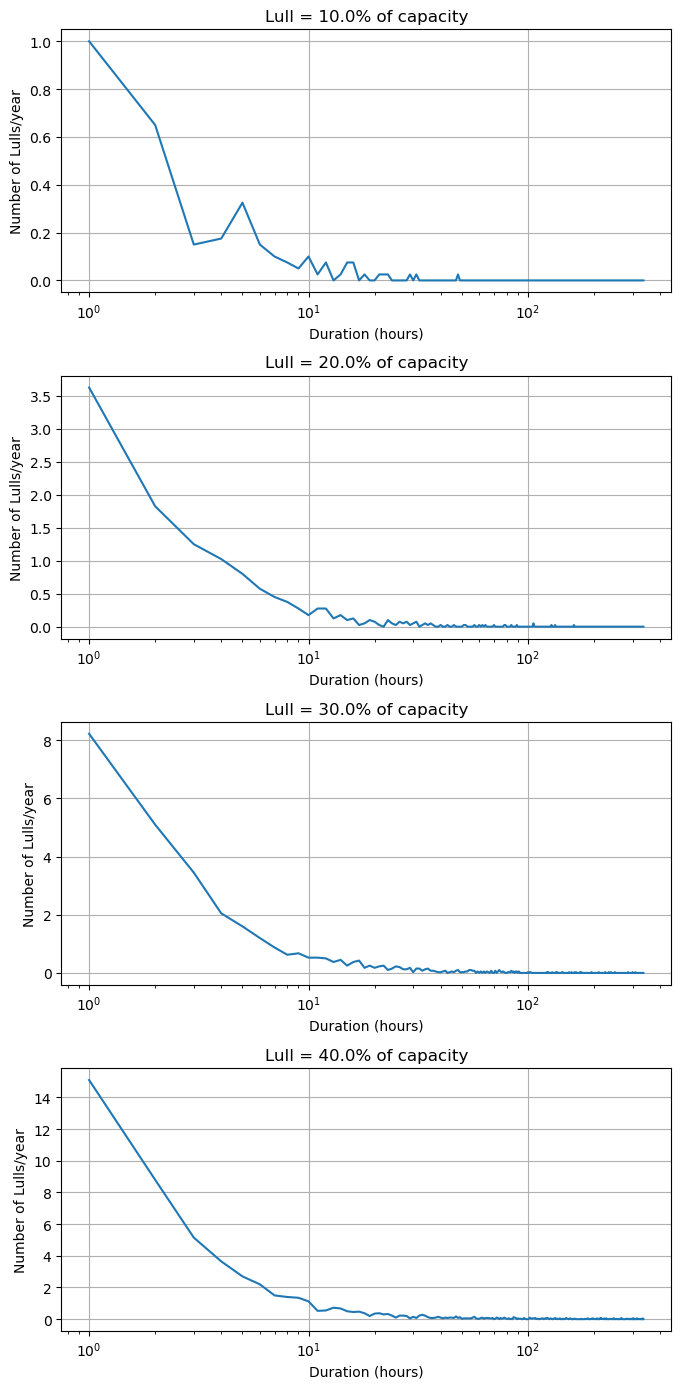

In [90]:
# Define your parameters
avg_nums = np.arange(1, 337)  # 1hr to 2 weeks
start_date = '1982-01-01'
end_date = '2022-12-31'
cut_offs = np.array([0.1, 0.2, 0.3, 0.4])
num_lulls = np.empty((cut_offs.shape[0], len(avg_nums)), dtype='float64')

n_turbs_grdpnt = 2409
turbine_rating = 8.3
loss_factor = 0.9

# Define the coordinates for the first set of turbines
coordinates_1 = [
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (54.25, 0.00),
    (54.25, -11.00)
]

agg_power = {}
for i, coord in enumerate(coordinates_1):
    lat, lon = coord
    lats = xr.DataArray([lat], dims='coords')
    lons = xr.DataArray([lon], dims='coords')
    agg_power[i] = ((ds['power'].sel(latitude=lats, longitude=lons) * n_turbs_grdpnt * loss_factor)
                    .sum(dim='coords')).compute()

# Aggregate power contributions from all coordinates
agg_power_total = sum(agg_power.values())
agg_power_total = agg_power_total / (1000 * 1000)

# Calculate maximum power for each cutoff value
max_power = 100
max_powers = max_power * cut_offs

# Cycle through cutoffs
for k, cut_off in enumerate(cut_offs):
    start = time.time()

    for i, num_hours in enumerate(avg_nums):
        working_ds = (agg_power_total.sel(time=slice(start_date, end_date))
                      .rolling(time=num_hours)
                      .mean())

        # Identify lulls where power is less than max_power for the current cutoff
        num = (working_ds.where(working_ds < max_powers[k]))
        num_next = num.where((num.shift(time=1).isnull()) & (num.shift(time=-1).isnull()))
        num_lulls[k, i] = num_next.count(dim='time').values

    end = time.time()
    print(f"Cutoff: {cut_off}, Time taken: {np.round(end - start, decimals=3)} secs")

# Plotting
num_plots = len(cut_offs)
fig, axes = plt.subplots(num_plots, 1, figsize=(7, 14))

for i in range(num_plots):
    axes[i].plot(avg_nums, num_lulls[i] / 40)
    axes[i].set_title(f'Lull = {cut_offs[i] * 100}% of capacity')
    axes[i].set_xlabel('Duration (hours)')
    axes[i].set_ylabel('Number of Lulls/year')
    axes[i].set_xscale('log')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Cutoff: 0.1, Time taken: 2.057 secs
Cutoff: 0.2, Time taken: 2.054 secs
Cutoff: 0.3, Time taken: 2.056 secs
Cutoff: 0.4, Time taken: 2.062 secs
Cutoff: 0.1, Time taken: 2.057 secs
Cutoff: 0.2, Time taken: 2.06 secs
Cutoff: 0.3, Time taken: 2.067 secs
Cutoff: 0.4, Time taken: 2.071 secs


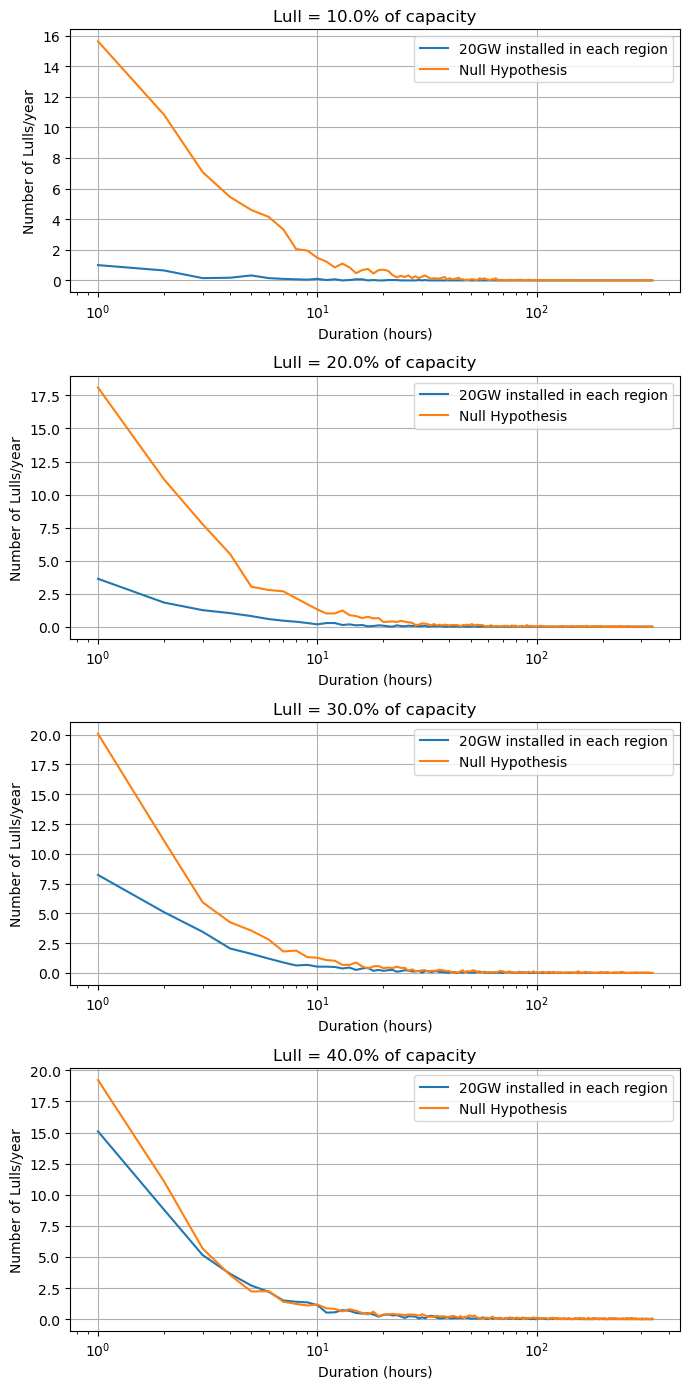

In [98]:
# Define your parameters
avg_nums = np.arange(1, 337)  # 1hr to 2 weeks
start_date = '1982-01-01'
end_date = '2022-12-31'
cut_offs = np.array([0.1, 0.2, 0.3, 0.4])
num_lulls = np.empty((cut_offs.shape[0], len(avg_nums)), dtype='float64')
num_lulls2 = np.empty((cut_offs.shape[0], len(avg_nums)), dtype='float64')

n_turbs_grdpnt = 2409
turbine_rating = 8.3
loss_factor = 0.9

# Define the coordinates for the first set of turbines
coordinates_1 = [
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (54.25, 0.00),
    (54.25, -11.00)
]

coordinates_2 = [
    (55.0, -10.00),
    (55.0, -10.00),
    (55.0, -10.00),
    (55.0, -10.00),
    (55.0, -10.00)
]

agg_power = {}
for i, coord in enumerate(coordinates_1):
    lat, lon = coord
    lats = xr.DataArray([lat], dims='coords')
    lons = xr.DataArray([lon], dims='coords')
    agg_power[i] = ((ds['power'].sel(latitude=lats, longitude=lons) * n_turbs_grdpnt * loss_factor)
                    .sum(dim='coords')).compute()

    
agg_power2 = {}
for i, coord in enumerate(coordinates_2):
    lat, lon = coord
    lats = xr.DataArray([lat], dims='coords')
    lons = xr.DataArray([lon], dims='coords')
    agg_power2[i] = ((ds['power'].sel(latitude=lats, longitude=lons) * n_turbs_grdpnt * loss_factor)
                    .sum(dim='coords')).compute()
    
# Aggregate power contributions from all coordinates
agg_power_total = sum(agg_power.values())
agg_power_total = agg_power_total / (1000 * 1000)

# Aggregate power contributions from all coordinates
agg_power_total2 = sum(agg_power2.values())
agg_power_total2 = agg_power_total2 / (1000 * 1000)

# Calculate maximum power for each cutoff value
max_power = 100
max_powers = max_power * cut_offs

# Cycle through cutoffs
for k, cut_off in enumerate(cut_offs):
    start = time.time()

    for i, num_hours in enumerate(avg_nums):
        working_ds = (agg_power_total.sel(time=slice(start_date, end_date))
                      .rolling(time=num_hours)
                      .mean())

        # Identify lulls where power is less than max_power for the current cutoff
        num = (working_ds.where(working_ds < max_powers[k]))
        num_next = num.where((num.shift(time=1).isnull()) & (num.shift(time=-1).isnull()))
        num_lulls[k, i] = num_next.count(dim='time').values

    end = time.time()
    print(f"Cutoff: {cut_off}, Time taken: {np.round(end - start, decimals=3)} secs")


    
# Cycle through cutoffs
for k, cut_off in enumerate(cut_offs):
    start = time.time()

    for i, num_hours in enumerate(avg_nums):
        working_ds2 = (agg_power_total2.sel(time=slice(start_date, end_date))
                      .rolling(time=num_hours)
                      .mean())

        # Identify lulls where power is less than max_power for the current cutoff
        num2 = (working_ds2.where(working_ds2 < max_powers[k]))
        num_next2 = num2.where((num2.shift(time=1).isnull()) & (num2.shift(time=-1).isnull()))
        num_lulls2[k, i] = num_next2.count(dim='time').values

    end = time.time()
    print(f"Cutoff: {cut_off}, Time taken: {np.round(end - start, decimals=3)} secs")
    
    
# Plotting
num_plots = len(cut_offs)
fig, axes = plt.subplots(num_plots, 1, figsize=(7, 14))

for i in range(num_plots):
    axes[i].plot(avg_nums, num_lulls[i] / 40, label = "20GW installed in each region")
    axes[i].plot(avg_nums, num_lulls2[i] / 40 , label = "Null Hypothesis")
    axes[i].set_title(f'Lull = {cut_offs[i] * 100}% of capacity')
    axes[i].set_xlabel('Duration (hours)')
    axes[i].set_ylabel('Number of Lulls/year')
    axes[i].legend(loc = "best")
    axes[i].set_xscale('log')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Cutoff: 0.01, Time taken: 2.061 secs
Cutoff: 0.1, Time taken: 2.055 secs
Cutoff: 0.2, Time taken: 2.065 secs
Cutoff: 0.3, Time taken: 2.068 secs
Cutoff: 0.4, Time taken: 2.065 secs
Cutoff: 0.01, Time taken: 2.059 secs
Cutoff: 0.1, Time taken: 2.061 secs
Cutoff: 0.2, Time taken: 2.066 secs
Cutoff: 0.3, Time taken: 2.068 secs
Cutoff: 0.4, Time taken: 2.074 secs
Cutoff: 0.01, Time taken: 2.064 secs
Cutoff: 0.1, Time taken: 2.063 secs
Cutoff: 0.2, Time taken: 2.064 secs
Cutoff: 0.3, Time taken: 2.066 secs
Cutoff: 0.4, Time taken: 2.072 secs


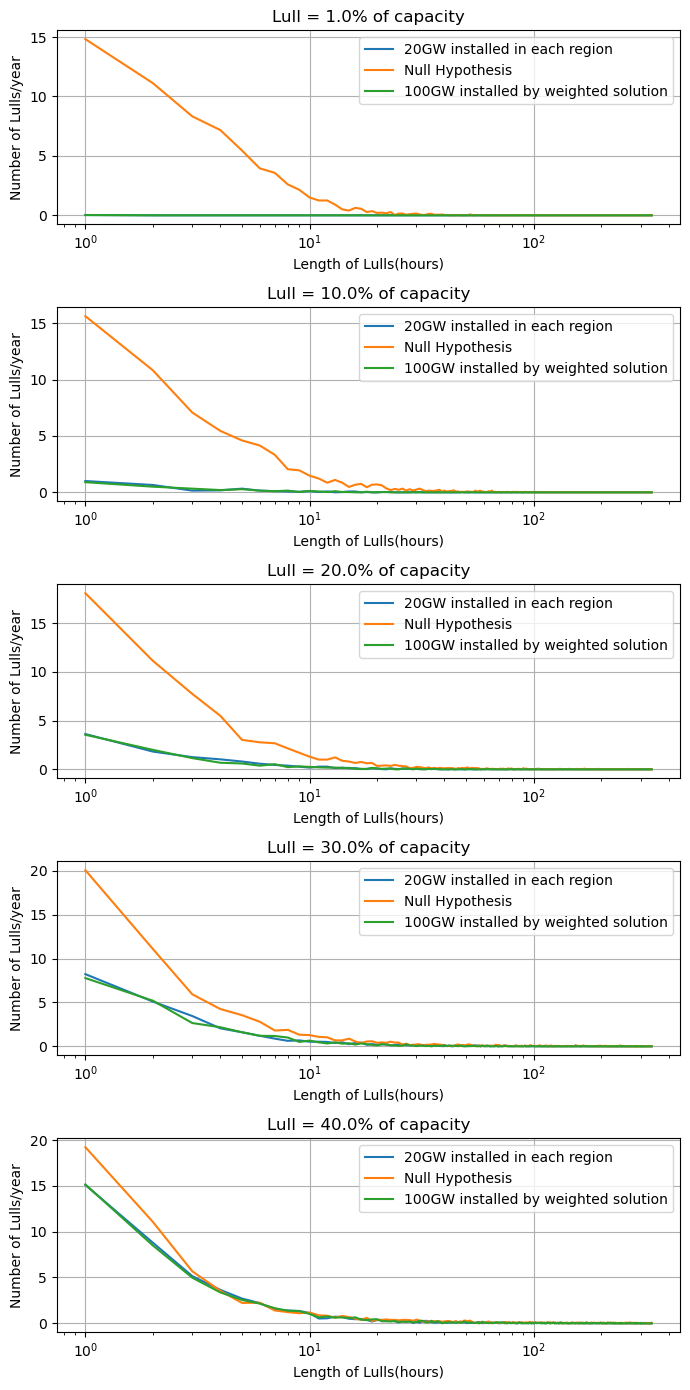

In [109]:
# Define your parameters
avg_nums = np.arange(1, 337)  # 1hr to 2 weeks
start_date = '1982-01-01'
end_date = '2022-12-31'
cut_offs = np.array([0.01,0.1, 0.2,0.3, 0.4])
num_lulls = np.empty((cut_offs.shape[0], len(avg_nums)), dtype='float64')
num_lulls2 = np.empty((cut_offs.shape[0], len(avg_nums)), dtype='float64')
num_lulls3 = np.empty((cut_offs.shape[0], len(avg_nums)), dtype='float64')

n_turbs_grdpnt = 2409
turbine_rating = 8.3
loss_factor = 0.9

# Define the coordinates for the first set of turbines
coordinates_1 = [
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (54.25, 0.00),
    (54.25, -11.00)
]

coordinates_2 = [
    (55.0, -10.00),
    (55.0, -10.00),
    (55.0, -10.00),
    (55.0, -10.00),
    (55.0, -10.00)
]

agg_power = {}
for i, coord in enumerate(coordinates_1):
    lat, lon = coord
    lats = xr.DataArray([lat], dims='coords')
    lons = xr.DataArray([lon], dims='coords')
    agg_power[i] = ((ds['power'].sel(latitude=lats, longitude=lons) * n_turbs_grdpnt * loss_factor)
                    .sum(dim='coords')).compute()

    
agg_power2 = {}
for i, coord in enumerate(coordinates_2):
    lat, lon = coord
    lats = xr.DataArray([lat], dims='coords')
    lons = xr.DataArray([lon], dims='coords')
    agg_power2[i] = ((ds['power'].sel(latitude=lats, longitude=lons) * n_turbs_grdpnt * loss_factor)
                    .sum(dim='coords')).compute()
    
# Aggregate power contributions from all coordinates
agg_power_total = sum(agg_power.values())
agg_power_total = agg_power_total / (1000 * 1000)

# Aggregate power contributions from all coordinates
agg_power_total2 = sum(agg_power2.values())
agg_power_total2 = agg_power_total2 / (1000 * 1000)

# Calculate maximum power for each cutoff value
max_power = 100
max_powers = max_power * cut_offs

# Cycle through cutoffs
for k, cut_off in enumerate(cut_offs):
    start = time.time()

    for i, num_hours in enumerate(avg_nums):
        working_ds = (agg_power_total.sel(time=slice(start_date, end_date))
                      .rolling(time=num_hours)
                      .mean())

        # Identify lulls where power is less than max_power for the current cutoff
        num = (working_ds.where(working_ds < max_powers[k]))
        num_next = num.where((num.shift(time=1).isnull()) & (num.shift(time=-1).isnull()))
        num_lulls[k, i] = num_next.count(dim='time').values

    end = time.time()
    print(f"Cutoff: {cut_off}, Time taken: {np.round(end - start, decimals=3)} secs")


    
# Cycle through cutoffs
for k, cut_off in enumerate(cut_offs):
    start = time.time()

    for i, num_hours in enumerate(avg_nums):
        working_ds2 = (agg_power_total2.sel(time=slice(start_date, end_date))
                      .rolling(time=num_hours)
                      .mean())

        # Identify lulls where power is less than max_power for the current cutoff
        num2 = (working_ds2.where(working_ds2 < max_powers[k]))
        num_next2 = num2.where((num2.shift(time=1).isnull()) & (num2.shift(time=-1).isnull()))
        num_lulls2[k, i] = num_next2.count(dim='time').values

    end = time.time()
    print(f"Cutoff: {cut_off}, Time taken: {np.round(end - start, decimals=3)} secs")
    
# Define the coordinates and their respective contributions to n_turbs_grdpnt
coordinates3 = [
    {'coord': (64.75, -11.00), 'n_turbs_grdpnt': 2556},
    {'coord': (61.25, -1.75), 'n_turbs_grdpnt': 2556},
    {'coord': (66.75, 3.75), 'n_turbs_grdpnt': 2556},
    {'coord': (54.25, 0.00), 'n_turbs_grdpnt': 2190},
    {'coord': (54.25, -11.00), 'n_turbs_grdpnt': 2190}
]

# Initialize dictionary to store aggregated power contributions
agg_power3 = {}

# Calculate aggregated power contributions for each coordinate
for i, coord_info in enumerate(coordinates3):
    coord = coord_info['coord']
    n_turbs_grdpnt = coord_info['n_turbs_grdpnt']
    lat, lon = coord
    lats = xr.DataArray([lat], dims='coords')
    lons = xr.DataArray([lon], dims='coords')
    agg_power3[i] = ((ds['power'].sel(latitude=lats, longitude=lons) * n_turbs_grdpnt * loss_factor)
                    .sum(dim='coords')).compute()

# Aggregate power contributions from all coordinates
agg_power_total3 = sum(agg_power3.values())
agg_power_total3 = agg_power_total3 / (1000 * 1000)

# Calculate maximum power for each cutoff value
max_power = 100
max_powers = max_power * cut_offs

# Cycle through cutoffs
for k, cut_off in enumerate(cut_offs):
    start = time.time()

    for i, num_hours in enumerate(avg_nums):
        working_ds3 = (agg_power_total3.sel(time=slice(start_date, end_date))
                      .rolling(time=num_hours)
                      .mean())

        # Identify lulls where power is less than max_power for the current cutoff
        num3 = (working_ds3.where(working_ds3 < max_powers[k]))
        num_next3 = num3.where((num3.shift(time=1).isnull()) & (num3.shift(time=-1).isnull()))
        num_lulls3[k, i] = num_next3.count(dim='time').values

    end = time.time()
    print(f"Cutoff: {cut_off}, Time taken: {np.round(end - start, decimals=3)} secs")
  
    
# Plotting
num_plots = len(cut_offs)
fig, axes = plt.subplots(num_plots, 1, figsize=(7, 14))

for i in range(num_plots):
    axes[i].plot(avg_nums, num_lulls[i] / 40, label = "20GW installed in each region")
    axes[i].plot(avg_nums, num_lulls2[i] / 40 , label = "Null Hypothesis")
    axes[i].plot(avg_nums, num_lulls3[i] / 40 , label = "100GW installed by weighted solution")
    axes[i].set_title(f'Lull = {cut_offs[i] * 100}% of capacity')
    axes[i].set_xlabel('Length of Lulls(hours)')
    axes[i].set_ylabel('Number of Lulls/year')
    axes[i].legend(loc = "best")
    axes[i].set_xscale('log')
    axes[i].grid(True)

plt.tight_layout()
plt.show()